# Pong-Playing TensorFlow Neural Network

## Import modules needed to train neural network in Pong environment

In [1]:
import gym
import numpy as np
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
import time

config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

%matplotlib inline

[2017-11-07 14:04:06,121] Making new env: Pong-v0


Discrete(6)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

## Investigate the environment and set up data preprocessing functions

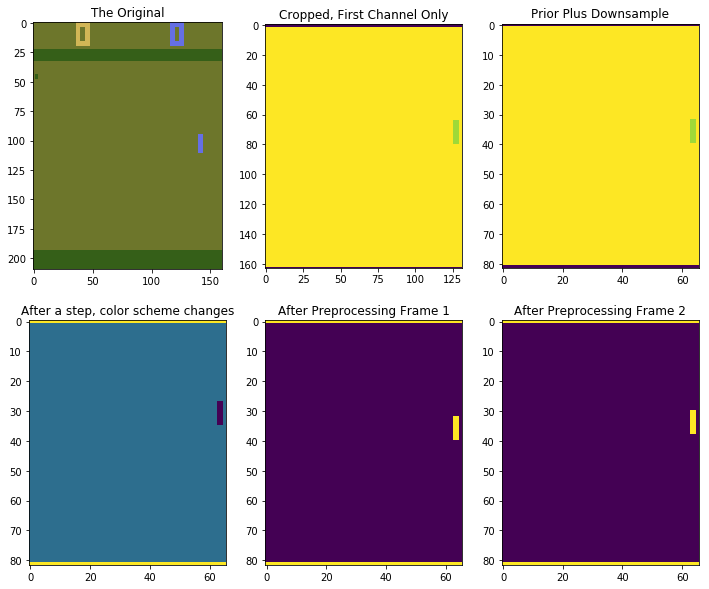

In [2]:
env = gym.make("Pong-v0")
env.render(mode='rgb_array').shape
env.reset()
print(env.action_space)
print(env.unwrapped.get_action_meanings())

top = 32
bottom = 195
left = 14
right = 146
downsampled_height = int(np.rint((bottom-top)/2))
downsampled_width = int(np.rint((right-left)/2))
input_dim = downsampled_height*downsampled_width

def preprocess(img, reshape=False):
    img = img[top:bottom,left:right,0][::2,::2] #crop, grab only one channel, and downsample by factor of 2
    img[np.isin(img,[144,109])] = 0 #get rid of background color, 109 in first frame, 144 otherwise
    img[img!=0] = 1
    if not reshape:
        return img.astype(np.int).ravel()
    else:
        return img.astype(np.int)

def reshape(img):
    return img.reshape(downsampled_height,downsampled_width).astype(np.int)

#what color pixels are in this image?
#print(list(zip(*np.unique(env.render(mode='rgb_array')[top:bottom,left:right,0],return_counts=1))))
#print(list(zip(*np.unique(env.render(mode='rgb_array')[top:bottom,left:right,0][::2,::2],return_counts=1))))

plt.subplots(2,3, figsize=(12,10))

plt.subplot(2,3,1)
plt.title("The Atari Pong Game Screen")
plt.imshow(env.reset())

plt.subplot(2,3,2)
plt.title("Cropped, First Channel Only")
plt.imshow(env.render(mode='rgb_array')[top:bottom,left:right,0])

plt.subplot(2,3,3)
plt.title("Prior Plus Downsample")
plt.imshow(env.render(mode='rgb_array')[top:bottom,left:right,0][::2,::2])

plt.subplot(2,3,4)
plt.title("After a step, color scheme changes")
plt.imshow(env.step(2)[0][top:bottom,left:right,0][::2,::2])

plt.subplot(2,3,5)
plt.title("After Preprocessing Frame 1")
plt.imshow(reshape(preprocess(env.reset())))

plt.subplot(2,3,6)
plt.title("After Preprocessing Frame 2")
plt.imshow(reshape(preprocess(env.step(2)[0])))
plt.show()

#print(list(zip(*np.unique(env.render(mode='rgb_array')[top:bottom,left:right,0][::2,::2],return_counts=1))))
#print(list(zip(*np.unique(reshape(preprocess(env.reset())),return_counts=1))))
#print(list(zip(*np.unique(reshape(preprocess(env.render(mode='rgb_array'))),return_counts=1))))

## Define and initialize the neural network

In [3]:
sess = tf.InteractiveSession(config=config)

x = tf.placeholder(tf.float32, shape=[None, input_dim])
advantage = tf.placeholder(tf.float32, shape=[None, 1])
action = tf.placeholder(tf.int8, shape=[None, 1])
move_down_action = tf.Variable(3, dtype=tf.int8)

h1_dim = 200
l1 = tf.layers.dense(x, h1_dim, activation=tf.nn.relu)
move_down_probability = tf.layers.dense(l1, 1, activation=tf.nn.sigmoid)
#log probability of action (3=down, 2=up)
sampled_action_log_prob = tf.where(tf.equal(action, move_down_action),
                                     tf.log(move_down_probability + 1e-8),
                                     tf.log(1-move_down_probability + 1e-8))
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
train = optimizer.minimize(tf.reduce_sum(-advantage*sampled_action_log_prob))

tf.global_variables_initializer().run()

## Set up an agent class that plays pong using actions chosen by the neural network in the active TensorFlow session

In [4]:
class pong_agent:
    
    def __init__(self):        
        self.wins = 0
        self.games = 0      
        self.discount = 0.99
        self.p_list = []
        self.actions = []
        self.frames = []
        self.rewards = []

    def make_batch(self, n_sets):
        for _ in range(n_sets):
            self.play_set()
        self.normalize_rewards()
        return self.rewards, self.frames, self.actions, self.p_list, self.wins, self.games

    def play_set(self):
        env.reset()
        done = 0
        while not done:
            self.frames.append(preprocess(env.render(mode='rgb_array')))
            done = self.play_point(self.frames[-1])

    def play_point(self, last_frame):
        while True:
            action, reward, new_frame, done = play_frame(self.frames[-1] - last_frame)
            self.actions.append(action)
            if reward:
                self.rewards += list(reward * np.array([ [self.discount**k]
                                        for k in range(len(self.frames)-1,-1,-1)]))
                self.wins += max(reward,0)
                self.games += 1
                break
            last_frame = self.frames[-1]
            self.frames.append(new_frame)
        return done

    def play_frame(self, frame_change):
        self.p_list.append( sess.run(move_down_probability,
                            feed_dict={x: np.array([frame_change])}).reshape(1))
        action = np.random.binomial(1, self.p_list[-1]) + 2 #sample an action using p_down, 3=down, 2=up
        observation, reward, done = env.step(action)[:3]
        return action, reward, preprocess(observation), done

    def normalize_rewards(self):
        mean = np.mean(self.rewards)
        std_dev = np.std(self.rewards)
        self.rewards = (np.array(self.rewards)-mean)/std_dev

## Train the agent for 2000 updates to reach >50% win rate

This part takes a while. My setup processes ~100 batches/hour. To monitor progress (percent of games won), I output a plot every 10 batches. There's a visible shift in the win rate from ~2% to ~4% by batch 300.

In [ ]:
start = time.time()
ratios = []
matches_per_batch = 10
epochs = 2000
agent = pong_agent()

for i in range(epochs):
    #play Pong with the network, save frames and associated rewards
    reward, frames, actions, p_list, w, g = agent.make_batch(matches_per_batch)
    train.run(feed_dict={x: frame_changes, advantage: reward, action: actions})
    ratios.append(w/g*100)
    if i%10==0:
        print("{}: batch {} finished after {} hours".format(time.strftime('%X %x '), 
                                                    i, round((time.time()-start)/3600,2)))
        plt.title("Agent Quality over Time")
        plt.plot(range(1,i+2), ratios)
        plt.xlabel("Number of Updates")
        plt.ylabel("Percent of Games Won")
        plt.savefig("./pong_agent_quality")
        if i%100==0:
            pass
            #save out the neural network here!!!!

Finished 0 batches in 0.01 hours
Finished 10 batches in 0.1 hours
Finished 20 batches in 0.19 hours
Finished 30 batches in 0.28 hours
Finished 40 batches in 0.37 hours
Finished 50 batches in 0.46 hours
Finished 60 batches in 0.55 hours
Finished 70 batches in 0.64 hours
Finished 80 batches in 0.74 hours
Finished 90 batches in 0.83 hours
Finished 100 batches in 0.92 hours
Finished 110 batches in 1.01 hours
Finished 120 batches in 1.11 hours
Finished 130 batches in 1.2 hours
Finished 140 batches in 1.3 hours
Finished 150 batches in 1.39 hours
Finished 160 batches in 1.49 hours
Finished 170 batches in 1.58 hours
Finished 180 batches in 1.68 hours
Finished 190 batches in 1.77 hours
Finished 200 batches in 1.87 hours
Finished 210 batches in 1.97 hours
Finished 220 batches in 2.06 hours
Finished 230 batches in 2.16 hours
Finished 240 batches in 2.26 hours
Finished 250 batches in 2.36 hours
Finished 260 batches in 2.46 hours
Finished 270 batches in 2.57 hours
Finished 280 batches in 2.67 hours

## View the last game played

In [ ]:
'''
watch the agent's Pong play in the most recent game, the title of the plot is the
probability with which the agent will move down. the right side of the plot is the 
difference frame that the agent/neural-network sees before computing the probability
'''
def concat(one, two):
    border = np.ones((downsampled_height,3))*3
    return np.concatenate([one,border,two], axis=1)

duration = 500 # number of frames to watch
game = frames
img = plt.imshow(concat(reshape(game[0]) , reshape(frame_changes[1]))) # only call this once
for i in range(min(len(game), duration)):
    img.set_data(concat(reshape(game[i]) , reshape(frame_changes[i]))) # just update the data
    plt.title("Move Down with Probability %.2f" % p_list[i][0])
    display.display(plt.gcf())
    display.clear_output(wait=True)